# Universidade Estadual de Campinas - Trabalho de Conclusão de Curso 
## Autor - João Velanes 237824

### Parte 1 - Import das bibliotecas a serem utilizadas no projeto 

In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import torch.nn.init as init
from torchmetrics import Precision, Recall, Accuracy
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from datetime import datetime



In [368]:
import warnings
warnings.filterwarnings('ignore')

In [369]:
df = pd.read_csv("Arquivo Concatenado/falha_2.csv")


In [370]:
df

timestamp       P-PDG       P-TPT       T-TPT  \
0       2018-05-13 01:53:17.000000  27840330.0  20228170.0  124.573200   
1       2018-05-13 01:53:18.000000  27840590.0  20228170.0  124.573200   
2       2018-05-13 01:53:19.000000  27840330.0  20228170.0  124.573200   
3       2018-05-13 01:53:20.000000  27840590.0  20228170.0  124.573200   
4       2018-05-13 01:53:21.000000  27840330.0  20228170.0  124.573200   
...                            ...         ...         ...         ...   
655012  2017-03-29 04:52:42.000000         0.0  10763410.0    8.439219   
655013  2017-03-29 04:52:43.000000         0.0  10764910.0    8.437844   
655014  2017-03-29 04:52:44.000000         0.0  10766400.0    8.436469   
655015  2017-03-29 04:52:45.000000         0.0  10767900.0    8.435095   
655016  2017-03-29 04:52:46.000000         0.0  10769400.0    8.433720   

        P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
0       4065790.0   90.81752         NaN         NaN  NaN    0.0  
1       4065790.0   90.81752         NaN         NaN  NaN    0.0  
2       4065790.0   90.81753         NaN         NaN  NaN    0.0  
3       4065790.0   90.81753         NaN         NaN  NaN    0.0  
4       4065790.0   90.81753         NaN         NaN  NaN    0.0  
...           ...        ...         ...         ...  ...    ...  
655012        NaN        NaN         NaN         NaN  2.0    NaN  
655013        NaN        NaN         NaN         NaN  2.0    NaN  
655014        NaN        NaN         NaN         NaN  2.0    NaN  
655015        NaN        NaN         NaN         NaN  2.0    NaN  
655016        NaN        NaN         NaN         NaN  2.0    NaN  

[655017 rows x 10 columns]

In [371]:
df["class"].unique() # Apagar colunas Ruins com poucos dados

array([  0., 102.,   2.,  nan])

In [372]:
df1 = df.copy()
df1["timestamp"] = pd.to_datetime(df1["timestamp"], format='mixed', dayfirst=True)
df1.drop(columns=["T-JUS-CKGL"], inplace=True)
df1.dropna(inplace=True)
df1["class"] = df1["class"].astype(str)
df1["class"].replace({"2.0":"1.0","102.0":"2.0"},inplace=True)
df1["class"] = df1["class"].astype(float)
df1["class"] = df1["class"].astype(int)
print(df1["class"].unique())
#df1.columns

[0 2 1]


In [373]:
df1.columns

Index(['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP',
       'P-JUS-CKGL', 'QGL', 'class'],
      dtype='object')

In [395]:
import plotly.express as px

# Define the columns to be selectable in the dropdown
columns_to_plot = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL']

# Create an initial plot
fig = px.scatter(df1
                 , x='timestamp', y=columns_to_plot[0], title='Data vs Time', color='class', symbol='class')

# Add a range slider to the x-axis
fig.update_xaxes(rangeslider_visible=True)

# Create dropdown options dynamically
dropdown_options = [
    {'label': col, 'value': col} for col in columns_to_plot
]

# Update layout with dropdown menu
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [{"y": [df1[col]]}],
                    "label": col,
                    "method": "restyle"
                } for col in columns_to_plot
            ],
            "direction": "down",
            "showactive": True,
            "x": 0.17,
            "y": 1.15,
            "xanchor": "left",
            "yanchor": "top"
        }
    ]
)

# Show the plot
fig.show()

In [375]:
def create_sequences(df, label_column, timestamp_column, window_size):
    """
    Create sequences from a pandas DataFrame for time-series classification,
    ensuring all data within each sequence is from the same year based on the timestamp.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing features, labels, and timestamp information.
    label_column (str): The name of the column in df that contains the labels.
    window_size (int): The size of the sliding window.
    timestamp_column (str): The name of the column that contains the timestamp information.

    Returns:
    np.array: Array of sequences created from the DataFrame.
    np.array: Array of sequence labels.
    """
    sequences = []
    sequence_labels = []

    # Ensure the timestamp is in datetime format
    df[timestamp_column] = pd.to_datetime(df[timestamp_column])

    # Extract the year from the timestamp
    df['year'] = df[timestamp_column].dt.year

    # Separate the features, labels, and year information
    features = df.drop(columns=[label_column, timestamp_column, 'year']).values
    labels = df[label_column].values
    years = df['year'].values

    for i in range(len(df) - window_size + 1):
        # Extract the window of features, labels, and years
        window_features = features[i:i + window_size]
        window_label = labels[i:i + window_size]
        window_years = years[i:i + window_size]

        # Check if all entries in the window are from the same year
        if np.all(window_years == window_years[0]):
            sequences.append(window_features)
            sequence_labels.append(window_label[-1])

    return np.array(sequences), np.array(sequence_labels)

In [376]:
# sns.scatterplot(x="timestamp",y="T-TPT",data=df.dropna(subset="T-TPT")[df.dropna(subset="T-TPT")["timestamp"].dt.strftime("%Y")<"2015"],hue="class")
# sns.set_theme() # to make style changable from defaults use this line of code befor using set_style
# sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
# plt.show()

In [377]:
# import torch
# import torch.nn as nn
# 
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.rnn = nn.RNN(
#             input_size=7,  # Number of input features
#             hidden_size=32,  # Number of units in the hidden layer
#             num_layers=5,  # Number of recurrent layers
#             batch_first=True)  # Batch dimension is first
#         self.fc = nn.Linear(32, 3)  # Fully connected layer for output
# 
#     def forward(self, x):
#         # Initialize hidden state with zeros (could be on GPU if available)
#         h0 = torch.zeros(5, x.size(0), 32).to(x.device)
# 
#         # Pass input and initial hidden state through the RNN
#         out, _ = self.rnn(x, h0)
# 
#         # Only take the output from the last time step
#         out = self.fc(out[:, -1, :])
# 
#         return out


In [378]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(
            input_size=7,  # Number of input features
            hidden_size=32,  # Number of units in the hidden layer
            num_layers=5,  # Number of recurrent layers
            batch_first=True)  # Batch dimension is first
        self.fc = nn.Linear(32, 3)  # Fully connected layer for output

    def forward(self, x):
        # Initialize hidden state with zeros (could be on GPU if available)
        h0 = torch.zeros(5, x.size(0), 32).to(x.device)
        c0 = torch.zeros(5, x.size(0), 32).to(x.device)
        # Pass input and initial hidden state through the RNN
        out, _ = self.lstm(x, (h0,c0))

        # Only take the output from the last time step
        out = self.fc(out[:, -1, :])

        return out


In [379]:
# class Classe2(Dataset):
#     def __init__(self,data):
#         super(Classe2, self).__init__()
#         self.data = data.to_numpy(dtype=np.float32) # Usar float 32 por que os pesos da Rede Neural sao Float32
#         #display(data)
#         
#     def __len__(self):
#         return self.data.shape[0]
#     def __getitem__(self, idx):
#         feature = self.data[idx,:-1]
#         label = int(self.data[idx,-1])
#         return feature, label

In [380]:
# Definindo o train test split usando um criterio temporal 
df1_train = df1[df1["timestamp"] < "2017-11-01"] ## ---> Treino com duas series antes de 2017
df1_test  = df1[df1["timestamp"] > "2017-11-01"] ## ---> Teste com uma serie depois de 2017

#
timestamp_train = df1_train["timestamp"]
timestamp_test = df1_test["timestamp"]

class_train = df1_train["class"]
class_test = df1_test["class"]

# Split X e y de treino
x_train = df1_train.drop(columns=["timestamp","class"])
y_train = df1_train["class"]

# Split X e y de teste
x_test = df1_test.drop(columns=["timestamp","class"])
y_test = df1_test["class"]

In [381]:
# Assuming x_train is a pandas DataFrame
#scaler = MinMaxScaler()
#scaler = MaxAbsScaler()
#scaler = Normalizer()
scaler = StandardScaler()
# Fit the scaler and transform the data
x_train_scaled = scaler.fit_transform(x_train)

# Convert the scaled data back to a DataFrame, preserving the column names
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns)

# Now x_train_scaled_df is a DataFrame with the same columns as x_train
x_train_scaled_df

P-PDG     P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  QGL
0        0.0  1.517625  1.111144   1.513961   0.858754    0.444931  0.0
1        0.0  1.517625  1.111142   1.513960   0.858754    0.444942  0.0
2        0.0  1.517625  1.111140   1.513959   0.858754    0.444954  0.0
3        0.0  1.517625  1.111137   1.513959   0.858754    0.444964  0.0
4        0.0  1.517625  1.111137   1.513958   0.858754    0.444975  0.0
...      ...       ...       ...        ...        ...         ...  ...
15755    0.0 -1.504462 -1.166870  -1.400201  -1.303918   -0.512775  0.0
15756    0.0 -1.504444 -1.167040  -1.400224  -1.303942   -0.512777  0.0
15757    0.0 -1.504427 -1.167211  -1.400247  -1.303967   -0.512777  0.0
15758    0.0 -1.504409 -1.167382  -1.400269  -1.303991   -0.512777  0.0
15759    0.0 -1.504391 -1.167552  -1.400292  -1.304016   -0.512778  0.0

[15760 rows x 7 columns]

In [382]:
# Fazendo o feature scaling para os dados teste
x_test_scaled = scaler.fit_transform(x_test)

# Convert the scaled data back to a DataFrame, preserving the column names
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)

# Now x_train_scaled_df is a DataFrame with the same columns as x_train
x_test_scaled_df.head()

P-PDG     P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL       QGL
0 -0.698667  0.820262  0.753017   0.748199   1.133351   -0.629742  0.451543
1 -0.698829  0.797022  0.741423   0.748483   1.133225   -0.632784  0.526413
2 -0.698951  0.773778  0.729830   0.748766   1.133095   -0.635827  0.601287
3 -0.699114  0.786343  0.738065   0.749048   1.132970   -0.638870  0.676156
4 -0.699236  0.798905  0.746300   0.749331   1.132839   -0.641912  0.751028

In [383]:
# Devolvendo a coluna de timestamp
x_train_scaled_timed_df = pd.concat([x_train_scaled_df,timestamp_train.reset_index(drop=True),class_train.reset_index(drop=True)],axis=1)
x_test_scaled_timed_df = pd.concat([x_test_scaled_df,timestamp_test.reset_index(drop=True),class_test.reset_index(drop=True)],axis=1)

x_train_scaled_timed_df["class"].value_counts()


class
0    7279
2    7172
1    1309
Name: count, dtype: int64

In [384]:

# Gerando as sequencias dos dados de treino e teste usando o algoritimo de sliding window
x_train_input,y_train_input =  create_sequences(df=x_train_scaled_timed_df, label_column="class", timestamp_column="timestamp", window_size=5)
x_test_input,y_test_input =  create_sequences(df=x_test_scaled_timed_df, label_column="class", timestamp_column="timestamp", window_size=5)

# dataset_train = TensorDataset(
#     torch.from_numpy(x_train_input).float32(),
#     torch.from_numpy(y_train_input).float32())


# Convert numpy arrays to PyTorch tensors and ensure correct data type
# Ensure the data is of type float32 before creating the TensorDataset
x_train_tensor = torch.from_numpy(x_train_input.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train_input).long()

# Create the TensorDataset
dataset_train = TensorDataset(x_train_tensor, y_train_tensor)

x_test_tensor = torch.from_numpy(x_test_input.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test_input).long()

# Create the TensorDataset
dataset_test = TensorDataset(x_test_tensor, y_test_tensor)



### Treinamento do Modelo

In [385]:
# Initialize dataset and dataloader
# dataset_train = Classe2(pd.concat([x_train_scaled_df.reset_index(drop=True), # Resetar e dropar index para concatenar corretamente 
#                                    y_train.reset_index(drop=True)], axis=1))

dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=False)

# Initialize the neural network, loss function, and optimizer
net = Net()

class_weights = torch.tensor([1.0, 2.0, 1.0])  # Adjust weights based on class importance
criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001) #0.00001

# Initialize metrics
metric_precision = Precision(task="multiclass", num_classes=3, average="weighted")
metric_recall = Recall(task="multiclass", num_classes=3, average="weighted")

# Loss storage
total_loss = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize epoch loss

    # Reset metrics at the beginning of each epoch
    metric_precision.reset()
    metric_recall.reset()

    for features, labels in dataloader_train:
        optimizer.zero_grad()  # Zero the parameter gradients

        # Infer the actual batch size for the current batch
        current_batch_size = features.size(0)

        # Reshape the features tensor with the inferred batch size
        features = features.view(current_batch_size, 5, 7) # batch_size, seq_len, num_features

        outputs = net(features)  # Forward pass

        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item()  # Accumulate loss

        # Calculate predictions and update metrics
        _, preds = torch.max(outputs, dim=1)
        metric_precision.update(preds, labels)
        metric_recall.update(preds, labels)
        total_loss.append(epoch_loss)

    # Compute average loss for the epoch
    average_loss = epoch_loss / len(dataloader_train)

    # Compute precision and recall for the epoch
    precision = metric_precision.compute()
    recall = metric_recall.compute()

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.6f}, Precision: {precision:.4f}, Recall: {recall:.4f}')


Epoch [1/50], Loss: 1.054628, Precision: 0.2131, Recall: 0.4616
Epoch [2/50], Loss: 1.033930, Precision: 0.2131, Recall: 0.4616
Epoch [3/50], Loss: 1.010336, Precision: 0.2131, Recall: 0.4616
Epoch [4/50], Loss: 0.981604, Precision: 0.3841, Recall: 0.4536
Epoch [5/50], Loss: 0.952654, Precision: 0.3820, Recall: 0.4556
Epoch [6/50], Loss: 0.930158, Precision: 0.4091, Recall: 0.4788
Epoch [7/50], Loss: 0.911480, Precision: 0.4450, Recall: 0.5113
Epoch [8/50], Loss: 0.889678, Precision: 0.5336, Recall: 0.5834
Epoch [9/50], Loss: 0.856701, Precision: 0.6383, Recall: 0.6840
Epoch [10/50], Loss: 0.806422, Precision: 0.7077, Recall: 0.7687
Epoch [11/50], Loss: 0.740880, Precision: 0.7458, Recall: 0.8139
Epoch [12/50], Loss: 0.666635, Precision: 0.7664, Recall: 0.8371
Epoch [13/50], Loss: 0.590665, Precision: 0.7790, Recall: 0.8509
Epoch [14/50], Loss: 0.522163, Precision: 0.7895, Recall: 0.8619
Epoch [15/50], Loss: 0.467715, Precision: 0.7966, Recall: 0.8693
Epoch [16/50], Loss: 0.426951, Pre

### Evaluation

In [394]:
import torch
from torchmetrics.classification import Precision, Recall
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# Assuming Classe2 and Net are defined elsewhere in your code

# Initialize dataset and dataloader for testing
# dataset_test = Classe2(pd.concat([x_test_scaled_df.reset_index(drop=True),
#                                   y_test.reset_index(drop=True)], axis=1))
#dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)  # Set shuffle=False for evaluation
dataloader_test = DataLoader(dataset_train, batch_size=32, shuffle=False)  # Set shuffle=False for evaluation
# Initialize metrics for evaluation
metric_precision = Precision(task="multiclass", num_classes=3, average=None)#"weighted")
metric_recall = Recall(task="multiclass", num_classes=3, average=None)#"weighted")

# Set the network to evaluation mode
net.eval()

all_labels = []
all_preds = []

# Disable gradient computation during evaluation
with torch.no_grad():
    for features, labels in dataloader_test:
        # Infer the actual batch size for the current batch
        current_batch_size = features.size(0)

        # Reshape the features tensor with the inferred batch size
        features = features.view(current_batch_size, 5, 7)  # batch_size, seq_len, num_features

        outputs = net(features)  # Forward pass
        _, preds = torch.max(outputs, dim=1)  # Get predictions

        # Update the metrics with predictions and true labels
        metric_precision.update(preds, labels)
        metric_recall.update(preds, labels)

        # Collect all labels and predictions for confusion matrix calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Compute the final precision and recall after processing all batches
precision = metric_precision.compute()
recall = metric_recall.compute()

# Print the evaluation results
print(f"Precision: {precision:}")
print(f"Recall: {recall:}")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
#print(conf_matrix)
conf_matrix


Precision: tensor([0.9864, 0.7969, 0.9910])
Recall: tensor([1.0000, 0.9534, 0.9417])
Confusion Matrix:


array([[7271,    0,    0],
       [   0, 1248,   61],
       [ 100,  318, 6754]], dtype=int64)

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix

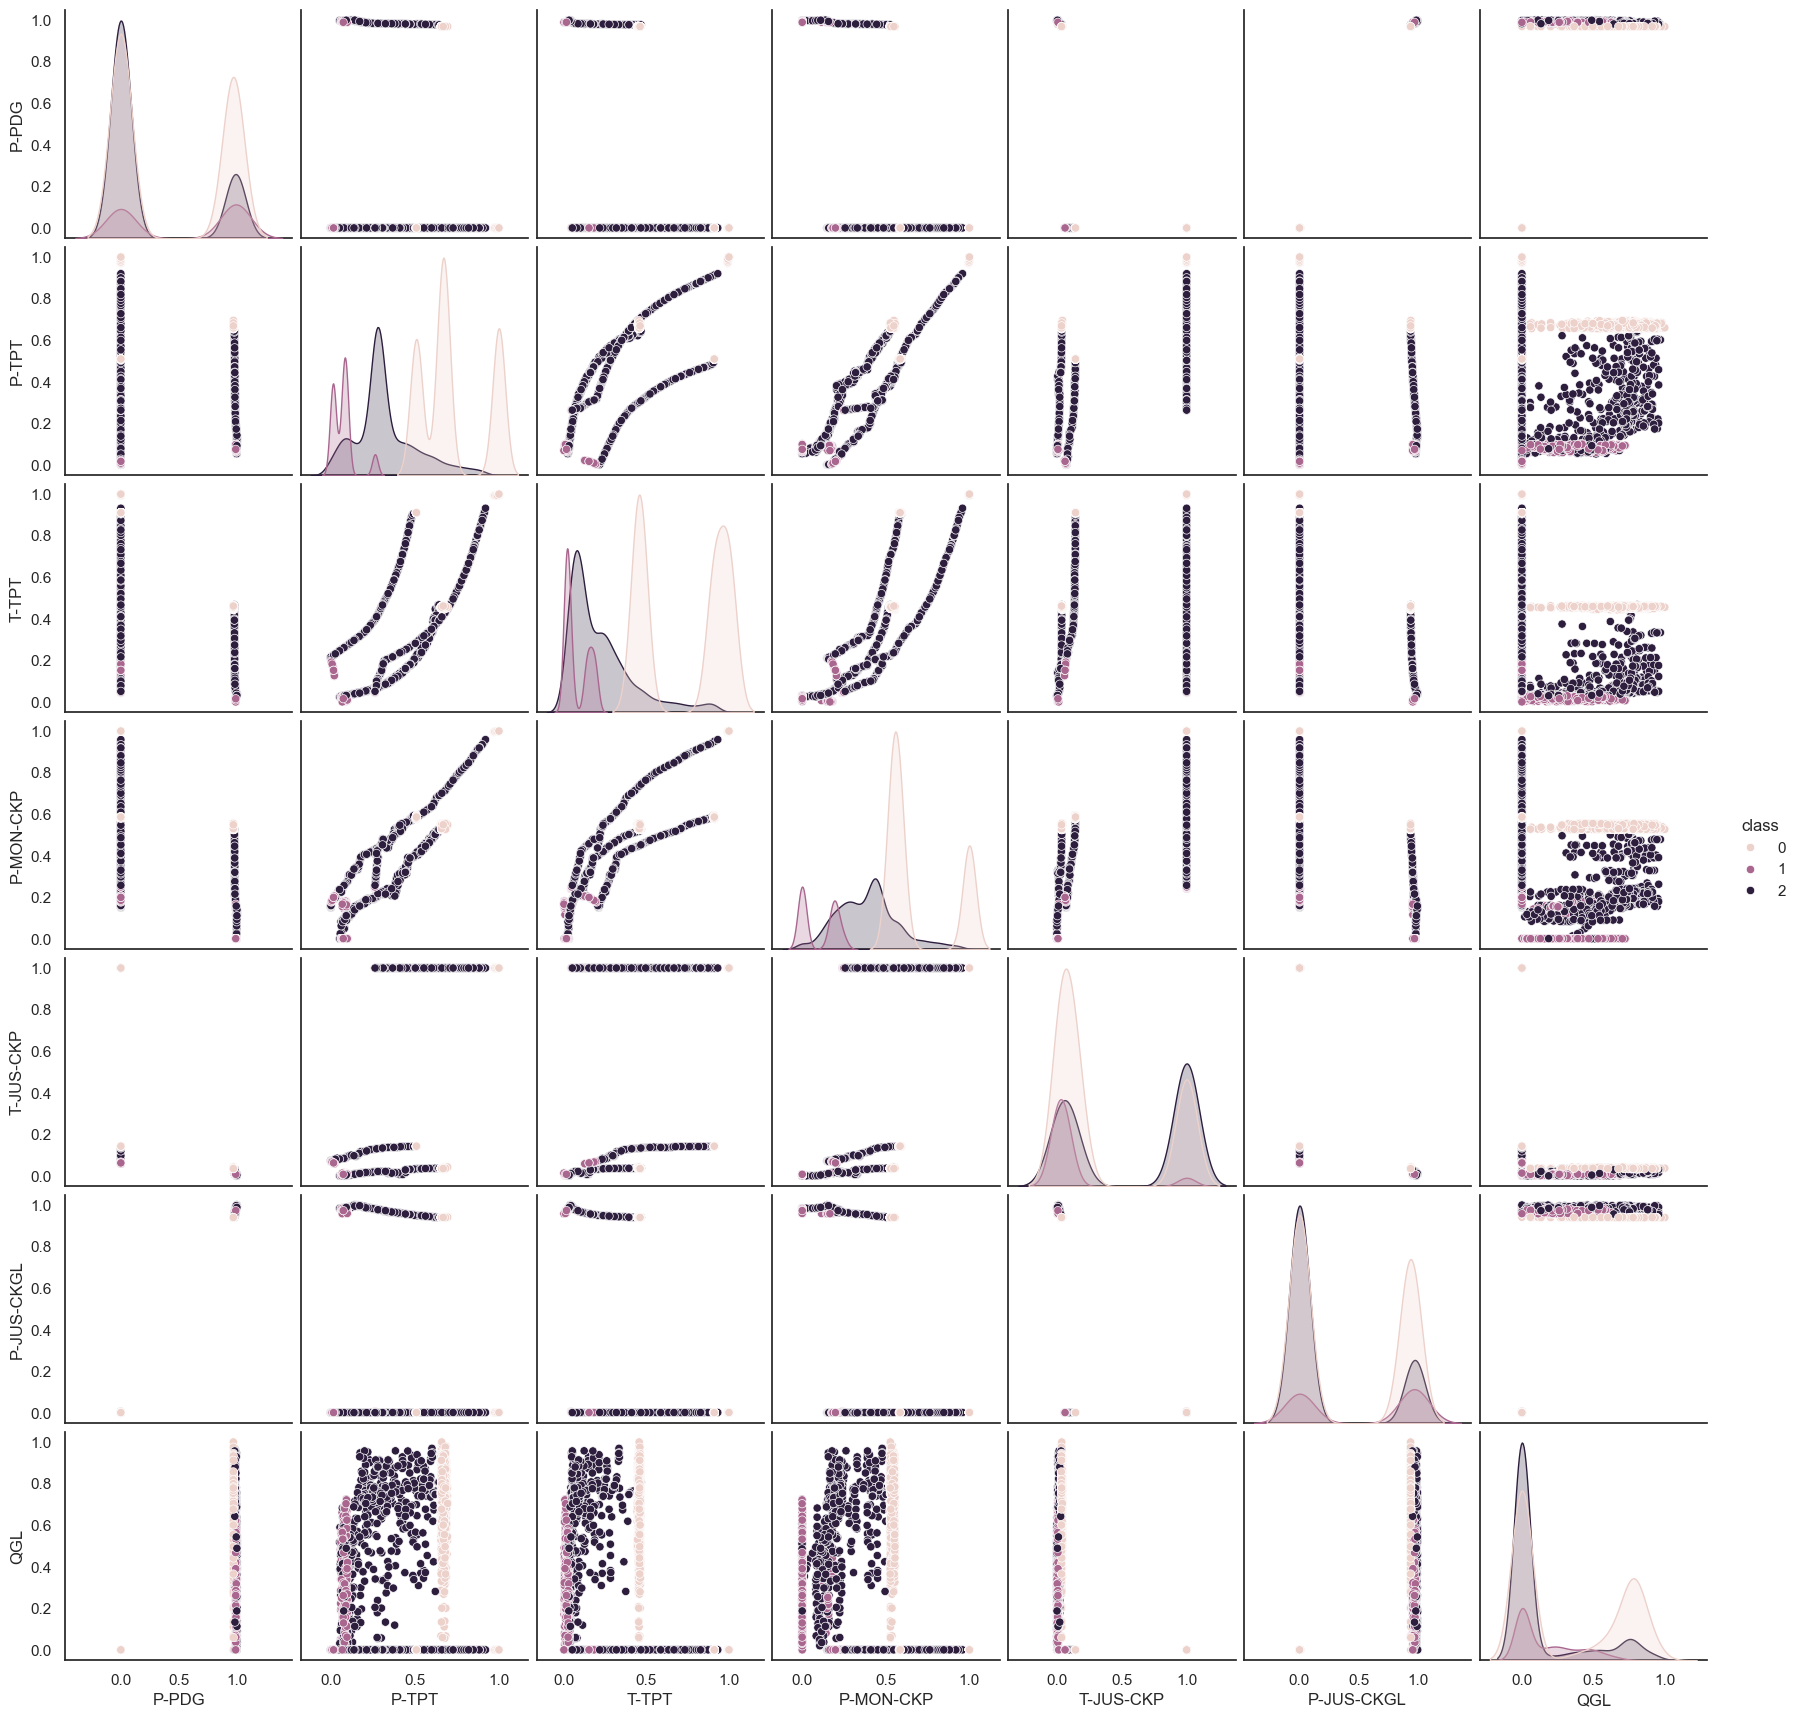

In [95]:
sns.set_style("white")

dados_teste = pd.concat([x_test_scaled_df.reset_index(drop=True),y_test.reset_index(drop=True)],axis=1)

sns.pairplot(dados_teste, hue="class")
